In [10]:
import argparse
import glob
from pathlib import Path
import open3d
import os

import numpy as np
import torch
import time
import demo as demo

from pcdet.config import cfg, cfg_from_yaml_file
from pcdet.datasets import DatasetTemplate
from pcdet.models import build_network, load_data_to_gpu
from pcdet.utils import common_utils


# 3 tool class, PillarVFE, PFNLayer, PointPillarScatter
from pcdet.models.backbones_3d.vfe import pillar_vfe as VFE
from pcdet.models.backbones_2d.map_to_bev import pointpillar_scatter as Scatter

os.environ["CUDA_VISIBLE_DEVICES"] = "5"
torch.cuda.set_device(5)

In [11]:
ckpt_path = './../output/kitti_models/pointpillar_copy/D_S2/ckpt/checkpoint_epoch_160.pth'
cfg_path = './cfgs/kitti_models/pointpillar_copy.yaml'
data_path = '/home/jiazx_ug/dataset/S2/A/training/velodyne/128976.bin'
txt_path = '/home/jiazx_ug/dataset/S2/A/training/label_2/128976.txt'


logger = common_utils.create_logger()   # logger.info('xxx')
# common_utils.set_random_seed(66)
logger.info('Test to get the VFE params' + time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
cfg_from_yaml_file(cfg_path, cfg)


demo_dataset = demo.DemoDataset(
    dataset_cfg=cfg.DATA_CONFIG, class_names=cfg.CLASS_NAMES, training=False,
    root_path=Path(data_path), ext='.bin', logger=logger
)

model = build_network(model_cfg=cfg.MODEL, num_class=len(cfg.CLASS_NAMES), dataset=demo_dataset)
model.load_params_from_file(filename=ckpt_path, logger=logger, to_cpu=True)

2024-03-08 10:15:31,041   INFO  Test to get the VFE params2024-03-08 10:15:31
2024-03-08 10:15:31,041   INFO  Test to get the VFE params2024-03-08 10:15:31
2024-03-08 10:15:31,041   INFO  Test to get the VFE params2024-03-08 10:15:31
2024-03-08 10:15:31,041   INFO  Test to get the VFE params2024-03-08 10:15:31
2024-03-08 10:15:31,159   INFO  ==> Loading parameters from checkpoint ./../output/kitti_models/pointpillar_copy/D_S2/ckpt/checkpoint_epoch_160.pth to CPU
2024-03-08 10:15:31,159   INFO  ==> Loading parameters from checkpoint ./../output/kitti_models/pointpillar_copy/D_S2/ckpt/checkpoint_epoch_160.pth to CPU
2024-03-08 10:15:31,159   INFO  ==> Loading parameters from checkpoint ./../output/kitti_models/pointpillar_copy/D_S2/ckpt/checkpoint_epoch_160.pth to CPU
2024-03-08 10:15:31,159   INFO  ==> Loading parameters from checkpoint ./../output/kitti_models/pointpillar_copy/D_S2/ckpt/checkpoint_epoch_160.pth to CPU
2024-03-08 10:15:31,199   INFO  ==> Checkpoint trained from version:

In [12]:
import torch
import kornia

voxel_size = torch.tensor([0.16, 0.16, 4])
pc_range = torch.tensor([-69.12, -39.68, -3., 69.12, 39.68, 1.])

def trans_data_2_tensor(batch_dict):
    for key, val in batch_dict.items():
        if key == 'camera_imgs':
            batch_dict[key] = val.cuda()
        elif not isinstance(val, np.ndarray):
            continue
        elif key in ['frame_id', 'metadata', 'calib', 'image_paths','ori_shape','img_process_infos']:
            continue
        elif key in ['images']:
            batch_dict[key] = kornia.image_to_tensor(val).float()
        elif key in ['image_shape']:
            batch_dict[key] = torch.from_numpy(val).int()
        else:
            batch_dict[key] = torch.from_numpy(val).float()

with torch.no_grad():
    for idx, data_dict in enumerate(demo_dataset):
        data_dict = demo_dataset.collate_batch([data_dict])
        trans_data_2_tensor(data_dict)

model_cfg = model.model_cfg
print(model_cfg)
num_point_features = model_cfg.VFE.NUM_FILTERS
num_point_features = 4

in_channels = 10
out_channels = 64
use_norm = True
last_layer = True
grid_size = [(pc_range[3] - pc_range[0]) / voxel_size[0], (pc_range[4] - pc_range[1]) / voxel_size[1], 1]
grid_size = torch.tensor(grid_size).int()


{'NAME': 'PointPillar', 'VFE': {'NAME': 'PillarVFE', 'WITH_DISTANCE': False, 'USE_ABSLOTE_XYZ': True, 'USE_NORM': True, 'NUM_FILTERS': [64]}, 'MAP_TO_BEV': {'NAME': 'PointPillarScatter', 'NUM_BEV_FEATURES': 64}, 'BACKBONE_2D': {'NAME': 'BaseBEVBackbone', 'LAYER_NUMS': [3, 5, 5], 'LAYER_STRIDES': [2, 2, 2], 'NUM_FILTERS': [64, 128, 256], 'UPSAMPLE_STRIDES': [1, 2, 4], 'NUM_UPSAMPLE_FILTERS': [128, 128, 128]}, 'DENSE_HEAD': {'NAME': 'AnchorHeadSingle', 'CLASS_AGNOSTIC': False, 'USE_DIRECTION_CLASSIFIER': True, 'DIR_OFFSET': 0.78539, 'DIR_LIMIT_OFFSET': 0.0, 'NUM_DIR_BINS': 2, 'ANCHOR_GENERATOR_CONFIG': [{'class_name': 'Car', 'anchor_sizes': [[3.9, 1.6, 1.56]], 'anchor_rotations': [0, 1.57], 'anchor_bottom_heights': [-1.78], 'align_center': False, 'feature_map_stride': 2, 'matched_threshold': 0.6, 'unmatched_threshold': 0.45}, {'class_name': 'Pedestrian', 'anchor_sizes': [[0.8, 0.6, 1.73]], 'anchor_rotations': [0, 1.57], 'anchor_bottom_heights': [-0.6], 'align_center': False, 'feature_map

In [13]:

class isPointInQuadrangle(object):

    def __int__(self):
        self.__isInQuadrangleFlag = False

    def cross_product(self, xp, yp, x1, y1, x2, y2):
        return (x2 - x1) * (yp - y1)-(y2 - y1) * (xp - x1)

    def compute_para(self, xp, yp, xa, ya, xb, yb, xc, yc, xd, yd):
        cross_product_ab = isPointInQuadrangle().cross_product(xp, yp, xa, ya, xb, yb)
        cross_product_bc = isPointInQuadrangle().cross_product(xp, yp, xb, yb, xc, yc)
        cross_product_cd = isPointInQuadrangle().cross_product(xp, yp, xc, yc, xd, yd)
        cross_product_da = isPointInQuadrangle().cross_product(xp, yp, xd, yd, xa, ya)
        return cross_product_ab,cross_product_bc,cross_product_cd,cross_product_da

    def is_in_rect(self, aa, bb, cc, dd):
        if (aa > 0 and bb > 0 and cc > 0 and dd > 0) or (aa < 0 and bb < 0 and cc < 0 and dd < 0):
            self.__isInQuadrangleFlag= True
        else:
            self.__isInQuadrangleFlag = False

        return self.__isInQuadrangleFlag

if __name__ == '__main__':
    aa, bb, cc, dd = isPointInQuadrangle().compute_para(600, 550, 508, 451, 730, 470, 718, 615, 495, 596)
    print(isPointInQuadrangle().is_in_rect(aa, bb, cc, dd))


True


In [14]:
import pandas as pd

pillarVFE = VFE.PillarVFE(model_cfg=model_cfg.VFE, num_point_features=num_point_features, voxel_size=voxel_size, point_cloud_range=pc_range)
pillarVFE.forward(data_dict)

pillarScatter = Scatter.PointPillarScatter(model_cfg=model_cfg.MAP_TO_BEV, grid_size=grid_size)
pillarScatter.forward(data_dict)

print('Done,',data_dict['spatial_features'].shape)
print(data_dict['voxel_coords'])

sum_all_pillar_features = torch.sum(data_dict['pillar_features'], dim=0)
sumsum_pillar_features = torch.sum(sum_all_pillar_features, dim=0)
print(sumsum_pillar_features)

sum_spatial_features = torch.sum(data_dict['spatial_features'])
print(sum_spatial_features)


Done, torch.Size([1, 64, 496, 864])
tensor([[  0.,   0., 324., 283.],
        [  0.,   0., 324., 286.],
        [  0.,   0., 325., 287.],
        ...,
        [  0.,   0., 241., 400.],
        [  0.,   0., 242., 400.],
        [  0.,   0., 243., 400.]])
tensor(2726444.7500, grad_fn=<SumBackward1>)
tensor(2726444.7500, grad_fn=<SumBackward0>)


[358 359 360 361 362 363 364 365 366 367 368 369] [122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
 158]
[-24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10  -9  -8  -7
  -6  -5  -4  -3  -2] [242 243 244 245 246 247 248 249 250 251 252]
[11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34
 35 36 37 38 39 40 41 42 43 44] [220 221 222 223 224 225 226 227 228 229 230]
[ 8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
 32 33 34 35 36 37 38 39 40 41 42 43 44] [263 264 265 266 267 268 269 270 271 272 273 274 275]
[413 414] [-24 -23]
[515 516] [314 315]
[-19 -18 -17 -16 -15 -14 -13 -12 -11 -10] [289 290 291 292 293]
[301 302 303 304 305 306 307 308 309] [655 656 657 658 659 660 661 662 663 664]
[440 441 442 443 444 445 446 447 448 449 450 451 452] [267 268 269 270 271]
[[359 123]
 [359 124]
 [359 125]
 ...
 [452 269]
 [452 270]
 [452 271]]


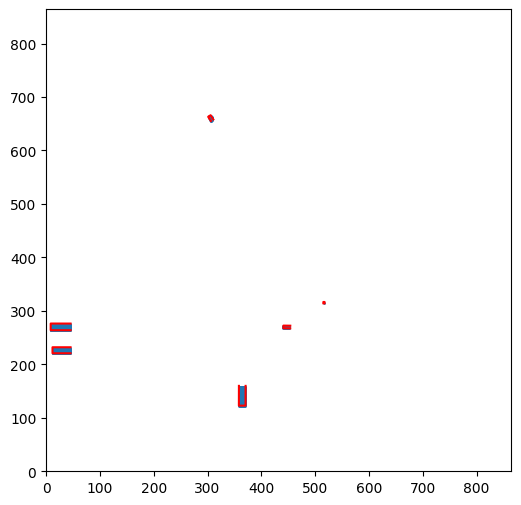

In [15]:
# read txt
import pandas as pd
import numpy as np
import open3d
import matplotlib.pyplot as plt

# pcd_path = '/home/ghosnp/dataset/mini_kitti/velodyne/training/velodyne/000011.bin'
# txt_path = '/home/ghosnp/dataset/mini_kitti/label_2/training/label_2/000011.txt'
POINT_CLOUD_RANGE = np.array([-69.12, -39.68, -3, 69.12, 39.68, 1], dtype=np.float32)

with open(txt_path, 'r') as f:
    txt = f.readlines()

pcd = np.fromfile(data_path, dtype=np.float32).reshape(-1, 4)
corners_bevs = []
corners_3Ds = []



for line in txt:
    line = line.split()
    lab, x, y, z, w, l, h, rot = line[0], line[11], line[12], line[13], line[9], line[10], line[8], line[14]
    h, w, l, x, y, z, rot = map(float, [h, w, l, x, y, z, rot])
    
    if lab != 'DontCare':
        x_corners = [l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2]
        y_corners = [0, 0, 0, 0, -h, -h, -h, -h]
        z_corners = [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2]
        corners_3d = np.vstack([x_corners, y_corners, z_corners])  # (3, 8)

        # transform the 3d bbox from object coordiante to camera_0 coordinate
        R = np.array([[np.cos(rot), 0, np.sin(rot)],
                    [0, 1, 0],
                    [-np.sin(rot), 0, np.cos(rot)]])
   
        corners_3d = np.dot(R, corners_3d).T + np.array([x, y, z])

        # transform the 3d bbox from camera_0 coordinate to velodyne coordinate
        corners_3d = corners_3d[:, [2, 0, 1]] * np.array([[1, -1, -1]])
        corners_3Ds.append(corners_3d)
        corners_bevs.append(corners_3d[:4, [0, 1]])
        
corners_bevs = np.array(corners_bevs)

# corners_bevs add range offset
corners_bevs[:, :, 0] += POINT_CLOUD_RANGE[3]
corners_bevs[:, :, 1] += POINT_CLOUD_RANGE[4]
corners_bevs /= 0.16


feature_idx = []
tool = isPointInQuadrangle()
# Get the index in the range of corners_bevs
for corners in corners_bevs:

    vector01 = corners[1] - corners[0]
    vector03 = corners[3] - corners[0]
    square_area = np.linalg.norm(vector01) * np.linalg.norm(vector03)
    max_x, min_x, max_y, min_y = np.max(corners[:,0]), np.min(corners[:,0]), np.max(corners[:,1]), np.min(corners[:,1])
    max_x, min_x, max_y, min_y = int(max_x), int(min_x), int(max_y), int(min_y)
    # get x,y with (min_x < x < max_x and min_y < y < max_y)
    x = np.arange(min_x, max_x)
    y = np.arange(min_y, max_y)
    print(x,y)
    temp_add = []
    for i in x:
        for j in y:
            a, b, c, d = tool.compute_para(i, j, corners[0][0], corners[0][1], corners[1][0], corners[1][1], corners[2][0], corners[2][1], corners[3][0], corners[3][1])
            res = tool.is_in_rect(a, b, c, d)
            if res:
                feature_idx.append([i, j])
                temp_add.append([i, j])
    
feature_idx = np.array(feature_idx)
print(feature_idx)

# visualize the block with feature_idx
fig = plt.figure(figsize=(6, 6))
for corners_bev in corners_bevs:
    plt.plot(corners_bev[:,0], corners_bev[:,1], 'r-')
plt.scatter(feature_idx[:,0], feature_idx[:,1], s=1)
plt.xlim(0, 864)
plt.ylim(0, 864)
plt.show()



In [16]:
# drop the idx out of the range(496,864)
feature_idx = feature_idx[feature_idx[:,0] < 496]
feature_idx = feature_idx[feature_idx[:,1] < 864]

spatial_features_cpu = data_dict['spatial_features'][0]
valid_features_cpu = spatial_features_cpu[:, feature_idx[:,0], feature_idx[:,1]]
sum_features_cpu = torch.sum(valid_features_cpu, dim=1)
sumsum_features_cpu = torch.sum(sum_features_cpu, dim=0)
mean_features_cpu = torch.mean(valid_features_cpu, dim=1)
# valid_features_cpu = valid_features_cpu.numpy()
# tensor.detach().numpy()
valid_features_cpu = valid_features_cpu.detach().numpy().T
print(valid_features_cpu.shape)

(1525, 64)


In [17]:
# feature_idx = feature_idx[feature_idx[:,0] < 496]
# feature_idx = feature_idx[feature_idx[:,1] < 864]

# # feature_idx load to gpu
# feature_idx_gpu = torch.from_numpy(feature_idx).cuda()
# # load the spatial_features, on gpu
# spatial_features_gpu = data_dict['spatial_features'][0].cuda()
# # spatial_features_gpu = data_dict['spatial_features'][0]
# # get the feature with feature_idx
# valid_features_gpu = spatial_features_gpu[:, feature_idx_gpu[:,1], feature_idx_gpu[:,0]]
# # sum the features
# sum_features_gpu = torch.sum(valid_features_gpu, dim=1)
# sumsum_features_gpu = torch.sum(sum_features_gpu, dim=0)
# print(sumsum_features_gpu)
# # mean the features
# mean_features_gpu = torch.mean(valid_features_gpu, dim=1)
# mean_features = mean_features_gpu.detach().numpy()
# valid_features = valid_features_gpu.detach().numpy().T


In [18]:

for name, param in model.named_parameters():
    # print(name, param.shape)
    if name == 'vfe.pfn_layers.0.linear.weight':
        vfe_pfn_weight = param.detach().cpu().numpy()
    elif name == 'vfe.pfn_layers.0.norm.weight':
        vfe_pfn_norm_weight = param.detach().cpu().numpy()
    elif name == 'vfe.pfn_layers.0.norm.bias':
        vfe_pfn_norm_bias = param.detach().cpu().numpy()
    else:
        pass

print(vfe_pfn_norm_weight.shape, mean_features_cpu.shape)
print(vfe_pfn_weight.shape)



(64,) torch.Size([64])
(64, 10)


In [19]:
# calcuate the  Pearson correlation coefficient (PCC) of the features
def cal_PCC(a,b):
    # a,b are two vectors, both are numpy array(64,)
    a_mean = np.mean(a)
    b_mean = np.mean(b)
    a_std = np.std(a)
    b_std = np.std(b)
    a = (a - a_mean) / a_std
    b = (b - b_mean) / b_std

    pcc = np.sum(a * b) / (64 - 1)
    return pcc

def cal_DIST(a,b):
    # a,b are two vectors, both are numpy array(64,)
    a_mean = np.mean(a)
    b_mean = np.mean(b)
    a_std = np.std(a)
    b_std = np.std(b)
    a = (a - a_mean) / a_std
    b = (b - b_mean) / b_std

    dist = np.sqrt(np.sum(np.square(a - b)))
    return dist



# random a 64 dim vector
random_vector = np.random.rand(64)
print('RAND',cal_PCC(random_vector, vfe_pfn_norm_weight), cal_DIST(random_vector, vfe_pfn_norm_weight))


new_valid_features = []
for i in range(valid_features_cpu.shape[0]):
    if np.sum(valid_features_cpu[i]) != 0:
        new_valid_features.append(valid_features_cpu[i])

new_mean_features = np.mean(new_valid_features, axis=0)
print('MEAN',cal_PCC(new_mean_features, vfe_pfn_norm_weight), cal_DIST(new_mean_features, vfe_pfn_norm_weight))

pccs , dists = [], []

for f in new_valid_features:
    norm_f = (f - np.mean(f)) / np.std(f)
    pcc = cal_PCC(norm_f, vfe_pfn_norm_weight)
    dist = cal_DIST(norm_f, vfe_pfn_norm_weight)
    pccs.append(pcc)
    dists.append(dist)

pillar_features = data_dict['pillar_features'].detach().cpu().numpy()

pccs_a, dists_a = [], []
for f in pillar_features:
    norm_f = (f - np.mean(f)) / np.std(f)
    pcc = cal_PCC(norm_f, vfe_pfn_norm_weight)
    dist = cal_DIST(norm_f, vfe_pfn_norm_weight)
    pccs_a.append(pcc)
    dists_a.append(dist)


RAND -0.022657316045839516 11.43917959255389
MEAN 0.1927175521850586 10.184184


In [20]:
print('VAILD')
print('PCC', np.mean(pccs), np.std(pccs))
print('DIST', np.mean(dists), np.std(dists))

print('ALL')
print('PCC', np.mean(pccs_a), np.std(pccs_a))
print('DIST', np.mean(dists_a), np.std(dists_a))



VAILD
PCC 0.19269155320667083 0.00015671873039988679
DIST 10.184344 0.0009699762
ALL
PCC 0.01800390163164613 0.129577776886127
DIST 11.188495 0.7410347


In [21]:
# # load data_dict['spatial_features'] to cpu
# spatial_features = data_dict['spatial_features'].detach().cpu().numpy()
# spatial_features = spatial_features[0]

# feature_idx = feature_idx[feature_idx[:,0] < 496]
# feature_idx = feature_idx[feature_idx[:,1] < 864]

# valid_features = np.array(spatial_features[:,  feature_idx[:,1], feature_idx[:,0]])

# # print(spatial_features.shape)


# # valid_features = np.array(spatial_features[:, feature_idx[:,1], feature_idx[:,0]])

# for name, param in model.named_parameters():
#     # print(name, param.shape)
#     if name == 'vfe.pfn_layers.0.linear.weight':
#         vfe_pfn_weight = param.detach().cpu().numpy()
#     elif name == 'vfe.pfn_layers.0.norm.weight':
#         vfe_pfn_norm_weight = param.detach().cpu().numpy()
#     elif name == 'vfe.pfn_layers.0.norm.bias':
#         vfe_pfn_norm_bias = param.detach().cpu().numpy()
#     else:
#         pass
# all_features = np.sum(spatial_features, axis=0)
# print("[ALL]")
# print(all_features)


# print("[MODEL]")

# print(vfe_pfn_norm_weight)

# # print("[DATA]")
# # # print(valid_features)
# # for f in valid_features:
# #     print(f)



In [22]:
from sklearn import svm


X_train = vfe_pfn_weight.T
X_test = valid_features_cpu
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.05)
clf.fit(X_train)

distances = np.abs(clf.decision_function(X_test))
print(np.mean(distances), np.std(distances))

all_features = data_dict['pillar_features'].detach().cpu().numpy()
distances = np.abs(clf.decision_function(all_features))
print(np.mean(distances), np.std(distances))

# DATA  -> MODEL
# C-S2 -> C-S2
# 0.019839489986762694 0.0450290048262891
# 0.12566919739974516 0.004066661647355991

# C-S2 -> B-S2
# 0.02273767303443326 0.04526851864487868
# 0.12930946103417057 0.003631496190221971

# C-S2 -> A-S2
# 0.023071117669783103 0.04811669151878394
# 0.1376982921235265 0.000912575582206974

# C-S2 -> D-S2
# 0.02362505405749544 0.04893671651987857
# 0.13929063141655862 0.003082539515942347

0.003513929565596339 0.007031162933601614
0.13864819321059274 0.004965254633415277


In [23]:
print(model.vfe.pfn_layers[0].linear.weight.shape)

torch.Size([64, 10])


In [24]:
# draw (distance-PCC), use matplotib.plt
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,5))
print(distances.shape)


(25452,)


<Figure size 600x500 with 0 Axes>